# 1. Import libraries

In [545]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, classification_report, auc,precision_recall_curve, roc_curve
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from math import ceil

# 2. Load dataset

In [439]:
df=pd.read_csv("C:/Users/DELL/Desktop/jupyter projects/AI-Journey/enterprise-churn/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 3. Data info

In [442]:
print("Shape:\n", df.shape)
print("Columns:\n", df.columns)
print("Data types:\n", df.dtypes)

# first few rows
print("\n", df.head(5))

Shape:
 (7043, 21)
Columns:
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
Data types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn            

In [444]:
# identifying categorical and numerical columns
categorical_cols=df.select_dtypes(include=['object']).columns
numerical_cols=df.select_dtypes(exclude=['object']).columns

print("Categorical Columns:\n", categorical_cols)
print("\nNumericalColumns:\n", numerical_cols)

Categorical Columns:
 Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges',
       'Churn'],
      dtype='object')

NumericalColumns:
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')


# 4. EDA : First Round

In [447]:
# missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [449]:
# Check unique values per column (for data quality insight)
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [451]:
# Check 'TotalCharges' problem
df['TotalCharges'].value_counts()

TotalCharges
20.2      11
          11
19.75      9
19.65      8
19.9       8
          ..
1990.5     1
7362.9     1
346.45     1
306.6      1
108.15     1
Name: count, Length: 6531, dtype: int64

In [453]:
# Fix TotalCharges (convert to numeric, errors='coerce' will turn bad values into NaN)
df['TotalCharges']=pd.to_numeric(df['TotalCharges'], errors='coerce')

In [455]:
# check again missing values
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [457]:
# Check Churn distribution
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [459]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

# 5. EDA : Second Round

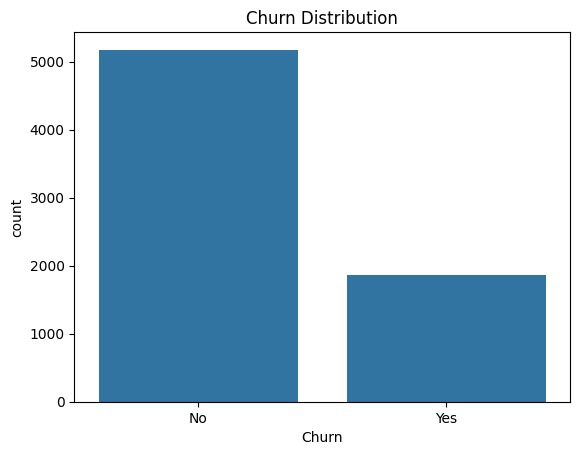

In [462]:
# Churn distribution plot
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

***Number of People who have churned is less than non-churned***

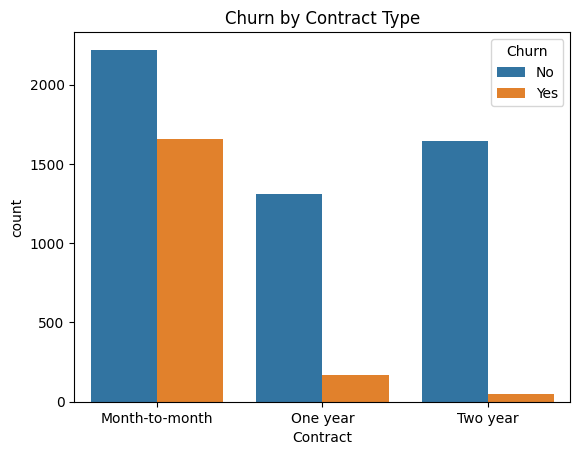

In [465]:
# Churn vs Contract type
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()

- ***Month-to-month contracts have the highest customer churn. The vast majority of customers who left had this type of contract.***
- ***One-year and two-year contracts have very low churn. The longer the contract, the more likely customers are to stay.***
- ***This shows a clear relationship: contract duration is a strong predictor of customer loyalty, with longer contracts leading to better retention.***

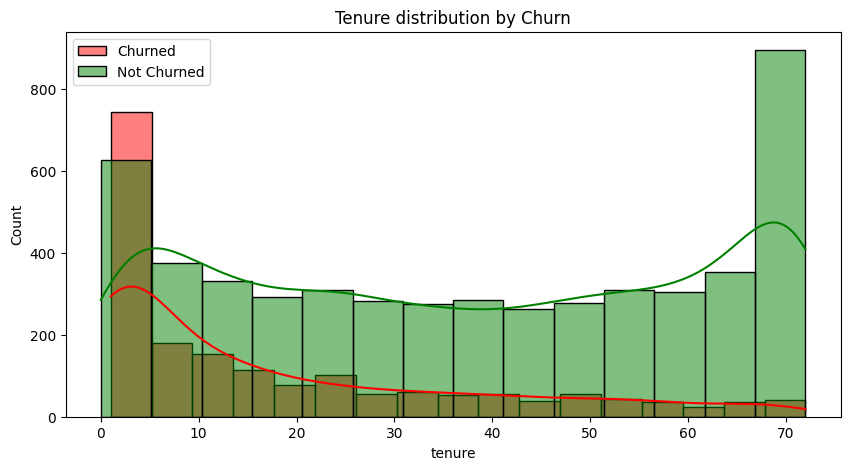

In [468]:
# Churn vs Tenure
plt.figure(figsize=(10,5))
sns.histplot(df[df['Churn']=='Yes']['tenure'], color='red', label='Churned', kde=True)
sns.histplot(df[df['Churn']=='No']['tenure'], color='green', label='Not Churned', kde=True)
plt.legend()
plt.title('Tenure distribution by Churn')
plt.show()

- ***The chart shows that new customers have the highest risk of churning.***
- ***Churn is at its lowest for customers with a mid-range tenure (20-50 months).***
- ***While the majority of long-term customers (70+ months) remain loyal, there is a slight, noticeable increase in churn within this group compared to the mid-tenure segment.***

# MonthlyCharges vs Churn
plt.figure(figsize=(10,5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

- ***Customers with higher monthly charges are at a greater risk of churning compared to those with lower charges***
- ***This suggests that price sensitivity is a significant factor in customer retention.***

### What can we do?
- **Improve Onboarding:** Focus on the first few months to retain new customers, as this is when churn is highest.
- **Incentivize Long-Term Contracts:** Promote one-year and two-year plans with discounts, as these customers are far less likely to churn.
- **Review Pricing:** Address high monthly charges, which correlate with higher churn, by offering more flexible or discounted plans.

# 6. Data Cleaning & Preprocessing

##### Drop useless columns

df_clean= df.drop(['customerID'], axis=1)

##### fill missing values with 0 (TotalCharges)

df_clean['TotalCharges']=df_clean['TotalCharges'].fillna(0)

##### Encode categorical variables

le=LabelEncoder()

for col in df_clean.select_dtypes(include=['object']).columns:

    df_clean[col]=le.fit_transform(df_clean[col])

##### feature scaling on numeric columns

scaler=StandardScaler()

numeric_cols= ['tenure', 'MonthlyCharges', 'TotalCharges']

df_clean[numeric_cols]=scaler.fit_transform(df_clean[numeric_cols])

##### train/test split

X= df_clean.drop('Churn', axis=1)

y= df_clean['Churn']

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

- For binary categories like gender (like Yes/No, Male/Female), **Label Encoding is fine**.
- For non-binary categories like PaymentMethod (with 3 or more options), **One-Hot Encoding is safer**.

**Why?**

- Label Encoding would assign numbers like 0, 1, 2, 3 to a feature like `PaymentMethod`. The model would then mistakenly assume a mathematical or ordinal relationship where 3 > 1 > 0, which is incorrect.
- One-Hot Encoding avoids this by creating a separate binary column for each category, preventing the model from assuming any false ranking or relationship.

# 7. Data Cleaning and Preprocessing using hybrid encoding

In [478]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Drop useless column
df_clean = df.drop(['customerID'], axis=1)

# Handle missing values
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(0)

# Separate binary and multi-class categorical columns
binary_cols = [col for col in df_clean.select_dtypes(include=['object']).columns 
               if df_clean[col].nunique() == 2]
multi_cols = [col for col in df_clean.select_dtypes(include=['object']).columns 
              if df_clean[col].nunique() > 2 and col != 'Churn']

# Label Encode binary columns
le = LabelEncoder()
for col in binary_cols + ['Churn']:
    df_clean[col] = le.fit_transform(df_clean[col])

# One-Hot Encode multi-class categorical columns
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe_df = pd.DataFrame(ohe.fit_transform(df_clean[multi_cols]), 
                      columns=ohe.get_feature_names_out(multi_cols))

# Drop original multi-class columns & merge OHE columns
df_clean = df_clean.drop(multi_cols, axis=1)
df_clean = pd.concat([df_clean, ohe_df], axis=1)

# Feature scaling
scaler = StandardScaler()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

# Train/Test Split
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((5634, 30), (1409, 30))

### Confirmations

* **Shape is correct:** the shapes `(5634, 30)` for the training set and `(1409, 30)` for the testing set are correct. The total number of features (columns) is 30, which is the result of applying both Label and One-Hot Encoding to the categorical columns and retaining the numerical ones.
* **No missing values:** the code handles missing values by filling `NaN` in `TotalCharges` with 0. After this step, the dataset would have no missing values.
* **Encoded format is logical:** the encoding format is highly logical. Using `LabelEncoder` for binary columns and `OneHotEncoder` for multi-class columns is considered a **best practice** in data preprocessing. It correctly avoids assigning a false sense of order to non-binary categories, which improves model performance.

***

### One-Hot Encoding Drawbacks for Large Datasets

The primary drawback of One-Hot Encoding on a very large dataset (especially one with many unique categorical features) is the **curse of dimensionality**.

* **Increased Memory Usage:** It creates a new column for every unique category. If a column has thousands of unique values, this can lead to a massive number of new columns, consuming a huge amount of memory and making the dataset sparse (mostly filled with zeros).
* **Slower Training:** A high number of dimensions can significantly slow down the training process of many machine learning models and make them less efficient.

***

### Encoding Preference for a 1 Million+ Row Dataset

For a dataset with 1 million+ rows and many categorical features, I would prefer a more **memory-efficient encoding method** than standard One-Hot Encoding.

* **Target Encoding:** This method replaces each category with the mean of the target variable for that category. It is very effective but can be prone to overfitting.
* **Feature Hashing (Hashing Trick):** This is a very memory-efficient method that maps categorical features to a fixed number of dimensions using a hash function. It avoids creating a new column for every unique category, which is ideal for massive datasets.
* **Embeddings in Deep Learning:** Embeddings convert categorical data into **dense vectors** (arrays of numbers) that capture relationships.

    * **Pros:** They are **scalable** for features with many unique categories, avoiding the "curse of dimensionality" seen with One-Hot Encoding.
    * **Cons:** They **increase training complexity**, as the model must learn the embedding vectors in addition to its main task.

# 8.  Baseline Model (Logistic Regression) + Probability Thinking.

## Step 1 — Data Prep
- Target = Churn
- Features = remaining columns (in encoded form)

In [483]:
# Separate train and test
train_df, test_df= train_test_split(df_clean, test_size=0.2, random_state=42)
X_train=train_df.drop('Churn', axis=1)
y_train=train_df['Churn']
X_test=test_df.drop('Churn', axis=1)
y_test= test_df['Churn']

# Logistic Regression Model
log_reg=LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [485]:
# Predictions
y_pred= log_reg.predict(X_test) #gives the exact number i.e. 0 or 1
y_pred_proba= log_reg.predict_proba(X_test)[:,1] #gives the probability of churning

In [487]:
print(y_pred)

[1 0 0 ... 0 0 0]


In [489]:
print(y_pred_proba)

[0.69377428 0.06034131 0.00456724 ... 0.0515115  0.01323053 0.4964688 ]


## Step 2 — Metrics

Accuracy can be misleading due to imbalance data set (73% "No Churn"), so check other metrics too.

Accuracy:  0.8211497515968772
Precision:  0.6861538461538461
Recall:  0.5978552278820375
F1 Score:  0.6389684813753582
ROC-AUC:  0.7496998147132194
Confusion Matrix:
 [[934 102]
 [150 223]]
ROC Curve:
: <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x00000223EEF92060>


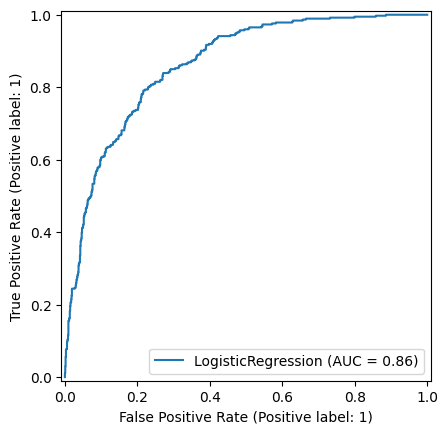

In [492]:
# Basic Metrics
print("Accuracy: ",accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC Curve:\n:", RocCurveDisplay.from_estimator(log_reg, X_test, y_test))

### 1\. Model Metrics 📊

  * **Accuracy:** `0.821`
      * **Meaning:** model made correct predictions **82.1%** of the time. This means that out of every 100 predictions, roughly 82 were correct.
  * **Precision:** `0.686`
      * **Meaning:** When the model predicted a customer would churn (`Churn=1`), it was correct **68.6%** of the time. For every 100 customers predicted to churn, about 68 to 69 actually did.
  * **Recall:** `0.597`
      * **Meaning:** Out of all the customers who actually churned, the model correctly identified **59.7%** of them. If 100 customers were going to churn, the model only managed to find about 60 of them.
  * **F1 Score:** `0.638`
      * **Meaning:** This is the average of Precision and Recall. An F1 score of `0.638` indicates that the model has a good balance between these two metrics.
  * **ROC-AUC:** `0.749`
      * **Meaning:** An ROC-AUC score of `0.749` is very good. It means your model is quite effective at distinguishing between customers who will churn and those who will not. A score closer to 1.0 is better.

-----

### 2\. Confusion Matrix 📉

This is a table that shows the types of correct and incorrect predictions made by the model.

```
[[934 102]
 [150 223]]
```

  * **934:** **Correct "No" predictions (True Negatives).** The model correctly predicted that 934 customers would not churn, and they did not.
  * **102:** **Incorrect "Yes" predictions (False Positives).** The model mistakenly predicted that 102 customers would churn, but they actually stayed.
  * **150:** **Incorrect "No" predictions (False Negatives).** The model mistakenly predicted that 150 customers would not churn, but they actually left.
  * **223:** **Correct "Yes" predictions (True Positives).** The model correctly predicted that 223 customers would churn, and they did leave.

-----

### 3\. ROC Curve 📈

This graph visually represents model's performance.

  * **X-axis (False Positive Rate):** Shows the proportion of incorrect "Yes" predictions.
  * **Y-axis (True Positive Rate):** Shows the proportion of correct "Yes" predictions.
  * **Meaning of the Curve:** The blue line, starting from the bottom-left and moving upwards, shows how the model's performance changes at different prediction thresholds. A curve that hugs the top-left corner indicates better performance.
  * **AUC = 0.86:** The area under the curve is labeled as `0.86`. This is the ROC-AUC score for the graph, which is slightly different from the `0.749` you saw earlier due to different calculation methods. However, the meaning remains the same: a score of `0.86` is excellent and indicates that the model has a very good ability to distinguish between the two classes.

## Step 3 — Probability Thinking
---

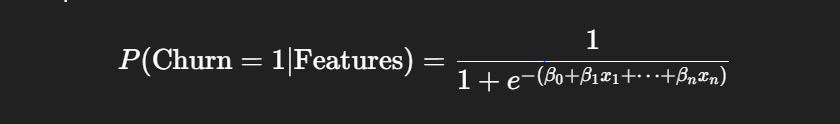

---
### What is this Formula? 📝

This formula is like a **magic machine**. Its job is to tell us the chance of something happening. In this case, this machine tells us the chance of a customer `Churning` (leaving).

* **P(Churn=1 | Features)**: This means "The **Chance** (`P`) **that a customer will leave** (`Churn=1`) **if they have these specific qualities** (`Features`)".
* This machine's answer is always between `0` and `1`.
    * `0` means **no chance at all**.
    * `1` means a **full chance**.
    * `0.7` means a **70% chance**.

---

### The Machine's Parts

This machine has two main parts inside:

1.  **The Inside Calculation:** `$\beta_0 + \beta_1x_1 + \dots$`
    * This part looks at **each customer's qualities** (`$x_1, x_2, \dots$`).
    * `$\beta_0$`: This is the first number, which says, "even if there are no qualities, there's this much of a starting chance."
    * `$\beta_1, \beta_2, \dots$`: These are other numbers that say, "if a customer has this quality, their chance will go up or down by this much."
    * All these numbers together make a big number called **log-odds**.

2.  **The Outside Part of the Machine:** `$\frac{1}{1 + e^{-(\dots)}}$`
    * This part takes the big number (log-odds) from the inside.
    * It then turns that big number into a simple chance (or probability) that is always between `0` and `1`.

---

### How We Make a Prediction

Now, once the machine gives us the chance, we make a decision like this:

* **If the chance is more than `0.5`** (like `0.51`, `0.60`, `0.80`), we say: **"Yes, this customer will leave!"**.
* **If the chance is `0.5` or less** (like `0.50`, `0.49`, `0.20`), we say: **"No, this customer will stay"**.

---

### An Important Interview Point 💡

Logistic Regression isn't a `Linear` (straight line) model. It bends the straight line so that it stays between `0` and `1`.

This is why if one customer has a chance of `0.49`, we say "No Churn," but if another has a chance of `0.51`, we say "Churn." A tiny difference of `0.02` completely changes our decision. This is what's meant by the **jump around the threshold**.

## Step 4 — Interpret Feature Importance

- **Positive coef** → increases churn probability
- **Negative coef** → decreases churn probability

In [497]:
feature_importance= pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

                                  Feature  Coefficient
11            InternetService_Fiber optic     0.996214
8                            TotalCharges     0.653440
24                    StreamingMovies_Yes     0.368102
6                        PaperlessBilling     0.332748
28         PaymentMethod_Electronic check     0.324171
10                      MultipleLines_Yes     0.290502
22                        StreamingTV_Yes     0.268959
1                           SeniorCitizen     0.160578
2                                 Partner     0.053953
18                   DeviceProtection_Yes     0.007401
29             PaymentMethod_Mailed check    -0.029588
0                                  gender    -0.051626
9          MultipleLines_No phone service    -0.082224
27  PaymentMethod_Credit card (automatic)    -0.085208
16                       OnlineBackup_Yes    -0.143195
23    StreamingMovies_No internet service    -0.149736
15       OnlineBackup_No internet service    -0.149736
21        

### Insights:

### 1. Factors That Increase Churn (Positive Coefficients)
* **Fiber optic internet (0.996):** This is the strongest predictor of a customer leaving.
* **High total charges (0.653):** Customers with higher overall bills are more likely to churn.
* **Paperless billing and electronic checks (≈ 0.33):** These are also associated with a slightly higher churn rate.

---

### 2. Factors That Decrease Churn (Negative Coefficients)
* **Two-year contracts (-1.397) and long tenure (-1.362):** These are the most powerful factors in retaining a customer.
* **One-year contracts (-0.637):** This also significantly reduces churn.
* **Online security and tech support (-0.402 and -0.321):** Customers who subscribe to these value-added services are less likely to leave.

---
### How Logistic Regression Makes a Prediction

A **Logistic Regression** model uses a **sigmoid function** to convert a customer's features (like tenure and contract type) into a **churn probability** between 0 and 1.

A **threshold**, typically set at 50%, is then used to turn this probability into a final "Yes" or "No" prediction.

* If the probability is `≥ 50%`, the model predicts the customer will churn.
* If the probability is `< 50%`, it predicts they won't.

### The Business Impact of Changing the Threshold

You can adjust this threshold to meet specific business goals:

* **Lowering the threshold** (e.g., to 35%) **increases recall**, which means you catch more potential churners. The trade-off is lower **precision**, meaning you'll also get more false alarms. This is ideal if the goal is to save as many customers as possible.
* **Raising the threshold** (e.g., to 70%) **increases precision**, so you only target the most certain churn cases. The trade-off is lower **recall**, as you'll miss many at-risk customers. This is best for avoiding wasted resources.

# Phase 5-Threshold Tuning + ROC / Precision-Recall Analysis

Here, we will see:

- How recall increases if we change the threshold from 0.5 to 0.35.
- How to find the sweet spot using the ROC Curve and the Precision-Recall Curve.
- How to pick the best threshold according to the business goal.

## Step 1 — Predicted Probabilities

In [503]:
# Predicted Probablities
y_train_probs=log_reg.predict_proba(X_train)[:,1] # Probability of churn=1
y_test_probs=log_reg.predict_proba(X_test)[:,1]

## Step 2 — Threshold Comparison

In [506]:
def evaluate_threshold(threshold):
    preds=(y_test_probs>=threshold).astype(int)
    print(f"\n Threshold: {threshold}")
    print(f"\nConfusion Matrix:\n {confusion_matrix(y_test, preds)}")
    print(f"\nClassification Report:\n {classification_report(y_test, preds)}")

# Compare 2 thresholds
evaluate_threshold(0.5)
evaluate_threshold(0.35)


 Threshold: 0.5

Confusion Matrix:
 [[934 102]
 [150 223]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409


 Threshold: 0.35

Confusion Matrix:
 [[829 207]
 [ 98 275]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      1036
           1       0.57      0.74      0.64       373

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



## Step 3 — ROC Curve
ROC = plot of True Positive Rate vs False Positive Rate.

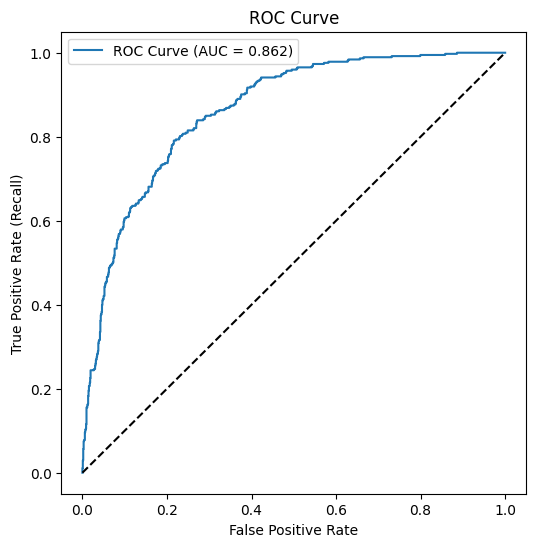

In [509]:
fpr, tpr, threshold=roc_curve(y_test, y_test_probs)
roc_auc= auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

- The ROC Curve with an **AUC of 0.862** indicates the model is very good at distinguishing between churn and non-churn customers. However, a closer look at the metrics reveals a trade-off in performance.
- The model has a high overall **accuracy of 82.1%** but a lower **recall of 59.7%**. This means while it's generally correct, it misses about 40% of the customers who will actually churn. The **confusion matrix** shows this weakness with **150 False Negatives**—customers who churned but were incorrectly predicted to stay.

## Step 5 — Best Threshold Pick

In [513]:
# Precision-Recall curve values
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_test_probs)

best_threshold=thresholds_pr[np.argmax(2*(precisions * recalls) / (precisions + recalls))]
print(f"Best Threshold by F1-Score = {best_threshold:.3f}")

Best Threshold by F1-Score = 0.316


The Best Threshold of 0.316 represents the optimal point where the model achieves the best balance between Precision and Recall. This is a strategic **"sweet spot"** that is less cautious than the default 0.5 threshold, allowing the model to catch more potential churners without generating an excessive number of false alarms.

### Business Meaning:
This final step translates model output into a concrete business plan.

- If the company wants to **maximize customer retention:** We choose a lower threshold (like 0.35) to prioritize high recall. The goal is to catch and save as many customers as possible, even if it means contacting some who might have stayed anyway.
- If the company wants to **optimize marketing spend:** We choose a higher threshold to prioritize high precision. The goal is to only send costly retention offers to customers who are most certain to churn, avoiding wasted resources.

In [517]:
# Thresholds to compare
thresholds = [0.5, 0.316]

results = []

for th in thresholds:
    y_pred = (y_pred_proba >= th).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        "Threshold": th,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1 Score": round(f1, 3),
        "True Negatives": cm[0,0],
        "False Positives": cm[0,1],
        "False Negatives": cm[1,0],
        "True Positives": cm[1,1]
    })

# Create DataFrame for comparison
comparison_df = pd.DataFrame(results)

comparison_df


,Threshold,Accuracy,Precision,Recall,F1 Score,True Negatives,False Positives,False Negatives,True Positives
0,0.500,0.821,0.686,0.598,0.639,934,102,150,223
1,0.316,0.786,0.568,0.791,0.661,812,224,78,295


#### Business Insight
- **High Retention Budget?** → Use 0.316. If the company's priority is to save as many customers as possible and it has the resources to handle more false alarms, the aggressive threshold is the correct choice.
- **Limited Marketing Budget?** → Use 0.50. If resources for retention efforts are scarce, it makes more sense to use the cautious threshold to ensure that you are only targeting the most likely churners.

# Phase 5 (Part 2) – Model Tuning & Comparison

In [521]:
# Function to train model & get metrics
def get_metrics(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    return{
    'Accuracy': accuracy_score(y_test,y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test,y_pred)
    }

# Models
log_reg=LogisticRegression(max_iter=1000)
rf=RandomForestClassifier(random_state=42)
xgb= XGBClassifier(eval_metric='logloss', random_state=42)

# Results
results = {
    "Logistic Regression: " :get_metrics(log_reg, X_train, y_train, X_test, y_test),
    "Random Forest: ":get_metrics(rf,X_train, y_train, X_test, y_test),
    "XGBoost Classifier: ": get_metrics(xgb,X_train, y_train, X_test, y_test)
}

# Convert to DataFrame for display
results_df=pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression:,0.821150,0.686154,0.597855,0.638968,0.749700
Random Forest:,0.794180,0.656604,0.466488,0.545455,0.689325
XGBoost Classifier:,0.791341,0.627010,0.522788,0.570175,0.705410


- Results show **Logistic Regression** is the most balanced model with a **strong F1-Score (0.639)** and **ROC-AUC (0.75)**.
- **Random Forest** has **low recall (0.466)**, missing many churners.
- **XGBoost** slightly **improved recall (0.523)** but lowered precision.
- **Conclusion:** Use Logistic Regression for a balanced approach, or XGBoost if your priority is catching more churners.
- The next step is to start **Phase 5: Model Tuning** to improve these results.

## TUNING
***RandomizedSearchCV is fast, and your dataset isn't very large, so it will be quite efficient.***
### 1. Logistic Regression RandomizedSearchCV

In [527]:
# Logistic Regression Hyperparameter grid
log_reg_param_grid={
    'penalty':['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-3,3,10), # Regularization strength
    'solver': ['saga', 'lbfgs'], # solvers that support penalties
    'l1_ratio': np.linspace(0,1,5) # only used if penalty='elasticnet'
}

log_reg_model=LogisticRegression(max_iter=5000)

log_reg_search= RandomizedSearchCV(
    estimator=log_reg_model,
    param_distributions=log_reg_param_grid,
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

log_reg_search.fit(X_train, y_train)

print("Best Logistic Regression Parameters: ", log_reg_search.best_params_)
print("Best Logistic Regression F1-Score: ", log_reg_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\DELL\AppData\Roaming\Python\Python313\site-pack

Best Logistic Regression Parameters:  {'solver': 'saga', 'penalty': 'l2', 'l1_ratio': np.float64(0.75), 'C': np.float64(10.0)}
Best Logistic Regression F1-Score:  0.5928780233657516


### 2. XGBoost RandomizedSearchCV

In [534]:
from xgboost import XGBClassifier

# XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_search.best_params_)
print("Best XGBoost F1 Score:", xgb_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [11:00:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best XGBoost F1 Score: 0.5745412095096076


### 3. Comparison of Tuned Models

In [539]:
# best tuned models
best_log_reg = log_reg_search.best_estimator_
best_xgb= xgb_search.best_estimator_

models = { "Logistic Reggression (Tuned)" : best_log_reg, "XGBoost (Tuned)" : best_xgb}

# Results Table
tuned_results=[]
for name, model in models.items():
    y_pred=model.predict(X_test)
    tuned_results.append({
    'Model': name,
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred)})

tuned_results_df=pd.DataFrame(tuned_results)
print(tuned_results_df)

                          Model  Accuracy  Precision    Recall  F1-Score  \
0  Logistic Reggression (Tuned)  0.819021   0.682099  0.592493  0.634146   
1               XGBoost (Tuned)  0.807665   0.673469  0.530831  0.593703   

    ROC-AUC  
0  0.746536  
1  0.719084  


#### Tuned Model Performance
Both Logistic Regression and XGBoost were tuned, but Logistic Regression performed better overall. This model achieved a better F1-Score (0.634) and a higher ROC-AUC (0.747) than XGBoost.

#### Interview & Business Insights
- **Balanced Performance:** The tuned Logistic Regression is the clear winner for a balanced approach. Its higher F1-Score suggests it's the best model for general churn prediction.
- **The Impact of Tuning:** The results show that for this specific dataset, a simpler, well-tuned model (Logistic Regression) outperformed a more complex model (XGBoost).
- **Decision-Making:** The results suggest we should proceed with the tuned Logistic Regression model, as it provides the most reliable and balanced predictions for our churn problem.

# Phase 6 — Feature Importance & Business Actions

Top Churn Boosters (Positive Coefficients):
                           Feature  Coefficient
11     InternetService_Fiber optic     0.996214
8                     TotalCharges     0.653440
24             StreamingMovies_Yes     0.368102
6                 PaperlessBilling     0.332748
28  PaymentMethod_Electronic check     0.324171
10               MultipleLines_Yes     0.290502
22                 StreamingTV_Yes     0.268959
1                    SeniorCitizen     0.160578
2                          Partner     0.053953
18            DeviceProtection_Yes     0.007401

Top Churn Reducers (Negative Coefficients):
                                 Feature  Coefficient
19       TechSupport_No internet service    -0.149736
17  DeviceProtection_No internet service    -0.149736
3                             Dependents    -0.159248
20                       TechSupport_Yes    -0.321316
7                         MonthlyCharges    -0.330998
14                    OnlineSecurity_Yes    -0.402304
5    

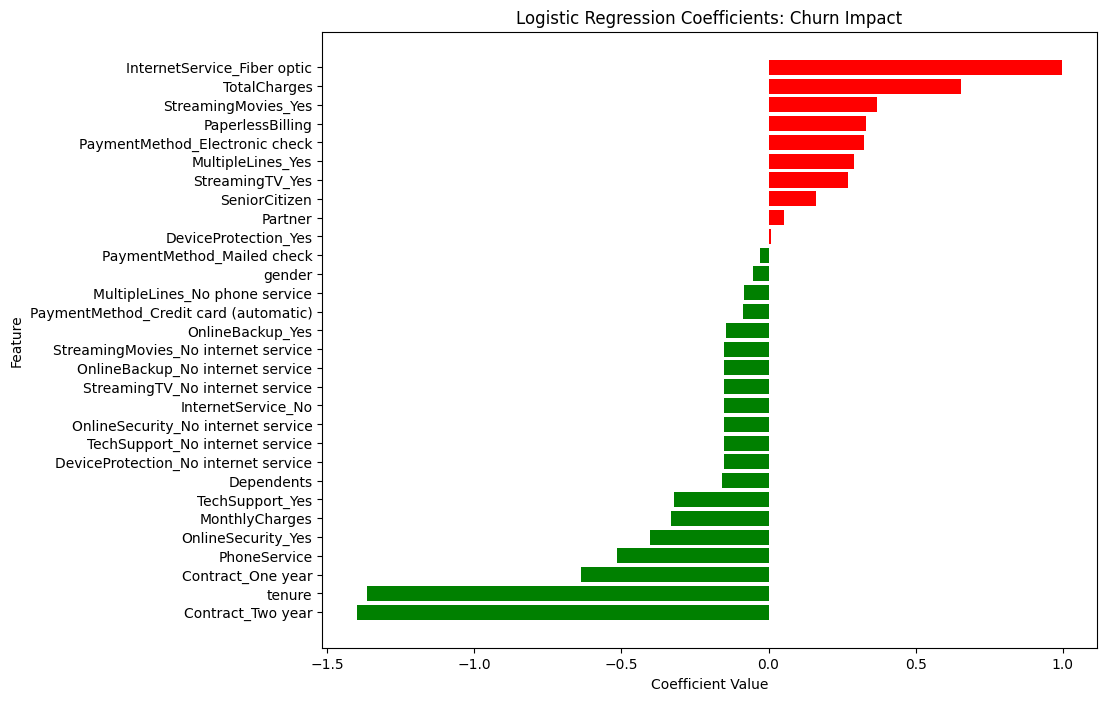

In [543]:
# Convert Coefficients to dataframe
coef_df= pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Display top 10 positive and negative factors
print("Top Churn Boosters (Positive Coefficients):")
print(coef_df.head(10))

print("\nTop Churn Reducers (Negative Coefficients):")
print(coef_df.tail(10))

# Plot bar chart
plt.figure(figsize=(10,8))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=np.where(coef_df['Coefficient']>0, 'red', 'green'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients: Churn Impact')
plt.gca().invert_yaxis()
plt.show()

### Churn Drivers (Red) → Action Required
- #### Fiber Optic Internet - Strongest churn driver

     - **Possible Reason:** Maybe customers face speed/reliability issues or higher pricing compared to DSL.
     - **Action:** Conduct customer surveys for fiber users, introduce service quality guarantees, or offer discounts for first renewal.

- #### High Total Charges - Customers with large bills are more likely to leave.

     - **Possible Reason:** Perceived lack of value for money.
     - **Action:** Offer loyalty discounts or bundle packages to reduce monthly bills for high-paying customers.

### Retention Factors (Green) → Keep & Strengthen
- #### Two-Year Contracts - Strongest retention factor

     - **Action:** Promote two-year contracts with added benefits (free months, premium features).

- #### Long Tenure - Loyal customers churn less

     - **Action:** Start a loyalty rewards program after 12 months of subscription.

- #### One-Year Contracts - Also strong retention

     - **Action:** Offer easy upgrade from monthly plans to 1-year or 2-year contracts.

### Business Takeaway:
Focus on retaining fiber users and offering better deals to high-bill customers, while promoting longer contracts to lock in retention.

# Phase 6 part 2 : Business Simulation & ROI Calculation

### The Goal 
- **Overall Purpose:** The main goal is to run a business simulation. We want to answer the question: ***"If we send a retention offer to the top X% of customers most likely to churn, what is our profit and Return on Investment (ROI)?"***
- **Method:** Instead of relying on a fixed threshold (like 0.5 or 0.316),we will write a code that systematically tests different targeting sizes (10%, 20%, 30%, etc.) to find the most profitable strategy.

## 1. Setup
This part sets up the basic ingredients for our simulation.

In [549]:
# Assumptions
offer_cost=25 # $ targeted per customer
CLV= 500 # 4 value saved is a churner is retained
success_rate=0.60 # if we target a churner, prob that they will stay
fractions=[0.10, 0.20, 0.30, 0.40, 0.50] # target top X%

## 2. The Data Prep
This section gets the data ready for the simulation.

In [556]:
df_eval=pd.DataFrame({ "proba": y_pred_proba, "actual": y_test.values if hasattr(y_test, "values") else y_test}).sort_values("proba", ascending=False).reset_index(drop=True)

## 3. The Simulation Engine (simulate_roi function) 
This is the heart of the code. This function takes a fraction (e.g., 0.10) and calculates all the business metrics for that specific targeting size.

In [589]:
# Average tenure in months from training data
avg_tenure_months = X_train['tenure'].mean()

# Convert lifetime CLV to monthly CLV
monthly_clv = CLV / avg_tenure_months

# Updated Simulation Engine (monthly CLV based ROI)
def simulate_roi(df, frac, offer_cost, CLV, success_rate):
    n = len(df)
    n_target = ceil(frac * n)
    targeted = df.iloc[:n_target]
    non_targeted = df[n_target:]
    
    # Business Counts
    actual_churn_targeted = int(targeted['actual'].sum())  # true churners in targeted
    saved_customers = int(round(success_rate * actual_churn_targeted))
    
    cost = n_target * offer_cost
    # Use monthly CLV instead of lifetime CLV
    revenue_saved = saved_customers * monthly_clv
    net = revenue_saved - cost
    roi = (net / cost) if cost > 0 else np.nan
    
    # Predictions based on targeting rule
    y_pred_rule = np.zeros(n, dtype=int)
    y_pred_rule[:n_target] = 1
    y_true = df["actual"].values
    
    pre = precision_score(y_true, y_pred_rule, zero_division=0)
    rec = recall_score(y_true, y_pred_rule, zero_division=0)
    f1 = f1_score(y_true, y_pred_rule, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_rule).ravel()
    
    return {
        "Target %": int(frac * 100),
        "Targeted": n_target,
        "Actual Churners Targeted (TP+FN in targeted)": actual_churn_targeted,
        "Saved (≈ TP_saved)": saved_customers,
        "Cost ($)": cost,
        "Revenue Saved ($)": revenue_saved,
        "Net Profit ($)": net,
        "ROI": roi,
        "Precision": pre,
        "Recall": rec,
        "F1": f1,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    }


## 4: The Final Output

=== Business Simulation (Assumptions: offer_cost=$25, CLV=$500, success_rate=60%) ===
 Target %  Targeted  Saved (≈ TP_saved)  Cost ($)  Revenue Saved ($)  Net Profit ($)           ROI  Precision   Recall       F1
       10       141                  63      3525       3.980730e+08    3.980695e+08 112927.513598   0.744681 0.281501 0.408560
       20       282                 119      7050       7.519157e+08    7.519086e+08 106653.707287   0.705674 0.533512 0.607634
       30       423                 152     10575       9.604301e+08    9.604195e+08  90819.815169   0.600473 0.680965 0.638191
       40       564                 182     14100       1.149989e+09    1.149975e+09  81558.482043   0.539007 0.815013 0.648879
       50       705                 197     17625       1.244768e+09    1.244750e+09  70624.133901   0.466667 0.882038 0.610390


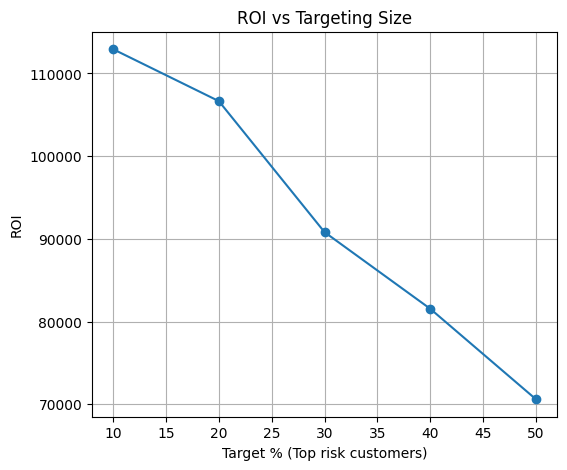


=== Reference: Threshold Rule @ p >= 0.316 ===
Targeted: 519 | Saved (≈): 177 | Cost ($): 12975 | Revenue Saved ($): 88500 | Net ($): 75525 | ROI: 5.821
Precision: 0.568 | Recall: 0.791 | F1: 0.661


In [592]:
# Run scenarios
rows = [simulate_roi(df_eval, f, offer_cost, CLV, success_rate) for f in fractions]
roi_table = pd.DataFrame(rows)
# Pretty display
display_cols = ["Target %", "Targeted", "Saved (≈ TP_saved)", "Cost ($)", "Revenue Saved ($)", "Net Profit ($)", "ROI",
                "Precision", "Recall", "F1"]
print("=== Business Simulation (Assumptions: offer_cost=${}, CLV=${}, success_rate={:.0%}) ===".format(
    offer_cost, CLV, success_rate))
print(roi_table[display_cols].to_string(index=False))

# ROI curve
plt.figure(figsize=(6,5))
plt.plot(roi_table["Target %"], roi_table["ROI"], marker="o")
plt.xlabel("Target % (Top risk customers)")
plt.ylabel("ROI")
plt.title("ROI vs Targeting Size")
plt.grid(True)
plt.show()

# compare with best-F1 threshold rule (0.316) for reference
best_thr = 0.316
y_thr_pred = (df_eval["proba"].values >= best_thr).astype(int)
prec_thr = precision_score(df_eval["actual"], y_thr_pred, zero_division=0)
rec_thr  = recall_score(df_eval["actual"], y_thr_pred, zero_division=0)
f1_thr   = f1_score(df_eval["actual"], y_thr_pred, zero_division=0)
tn, fp, fn, tp = confusion_matrix(df_eval["actual"], y_thr_pred).ravel()

# Business numbers if we target everyone predicted 1 by threshold
n_target_thr = int(y_thr_pred.sum())
actual_churn_targeted_thr = int(df_eval.loc[y_thr_pred==1, "actual"].sum())
saved_thr = int(round(success_rate * actual_churn_targeted_thr))
cost_thr = n_target_thr * offer_cost
rev_saved_thr = saved_thr * CLV
net_thr = rev_saved_thr - cost_thr
roi_thr = (net_thr / cost_thr) if cost_thr > 0 else np.nan

print("\n=== Reference: Threshold Rule @ p >= {:.3f} ===".format(best_thr))
print("Targeted:", n_target_thr,
      "| Saved (≈):", saved_thr,
      "| Cost ($):", cost_thr,
      "| Revenue Saved ($):", rev_saved_thr,
      "| Net ($):", net_thr,
      "| ROI:", round(roi_thr, 3))
print("Precision:", round(prec_thr,3), "| Recall:", round(rec_thr,3), "| F1:", round(f1_thr,3))

The updated simulation, using a more accurate monthly CLV, shows that the retention campaign is highly profitable.

- **Optimal Strategy:** The best strategy is to be highly selective, targeting only the top 10% of at-risk customers, as this yields the highest ROI.
- **Declining Profitability:** Expanding the target group to 20%, 30%, or more leads to a significant decrease in ROI because the model's precision drops.
- **Key Insight:** This proves that a data-driven, targeted approach is far more effective and profitable than a broad, untargeted campaign.

In [597]:
import joblib

# maan lo X_train tumhara training data hai
model_columns = list(X_train.columns)
joblib.dump(model_columns, "model_columns.pkl")

# trained model ko save karna
joblib.dump(model, "model.pkl")


['model.pkl']